# Python 3 and the geodesic algorithm

All the code for the algorithm is pulled from [this thesis](https://core.ac.uk/download/pdf/52106179.pdf)

There may be errors because of indentation screw ups.

So here is the schema from [this paper](https://arxiv.org/pdf/math/0605532.pdf)

![](./geod_algo.png)

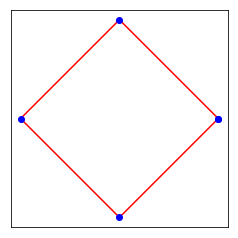

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

def plt_cplx(arr, sty='r', ax=None):
    if not ax:
        plt.plot(arr.real, arr.imag,sty)
    else:
        ax.plot(arr.real, arr.imag,sty)

def diamond(npts):
    verts = [1, 1J, -1,-1J]
    verts = [complex(x) for x in verts]
    #verts = [(1+1J)*v for v in verts]
    # add a copy of the first vertex ie path.close()
    verts.append(verts[0])

    #reparametrize using arclength
    side_lengths = [abs(a - b ) for a,b in zip(verts, verts[1:]) ]
    xs = np.zeros(len(verts))
    xs[1:] = np.cumsum(side_lengths)
    return np.interp(np.linspace(xs[0], xs[-1], npts + 1), xs, verts)

ZS = diamond(4)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt_cplx(ZS);
plt_cplx(ZS, sty='bo', ax=ax);

### Most of the papers 

show the image of a Carleson grid mapped into the domain
[don't they ?](https://www.dumas.io/teaching/2013/spring/math570/handouts/mapping.pdf)

![](https://empathicdynamics.files.wordpress.com/2017/01/screenshot-from-2017-01-19-17-09-33-1.png?w=512)



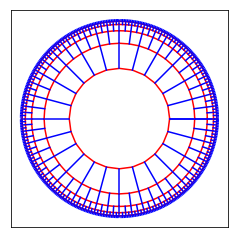

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

for k in range(1,6):
    ee = .5**k
    T = np.linspace(0,2*np.pi,12*2**k +1)
    X = np.cos(T)
    Y = np.sin(T)
    ax.plot((1 - ee) *X,(1 - ee) *Y,'r');
    for a,b in zip(X,Y):
        ax.plot([(1 - ee) *a, (1 - .5*ee) *a],
                [(1 - ee) *b, (1 - .5*ee) *b],'b');

## Let's start 

I don't really like the function names in the thesis
so I'll begin by changing some of them.

```plane2disc(1J,z)``` is a  the [Cayley transform](https://en.wikipedia.org/wiki/Cayley_transform#Complex_homography).

<img src="https://upload.wikimedia.org/wikipedia/commons/3/36/Cayley_transform_in_complex_plane.png" width="360" >

source: Wikipedia

In [4]:
# the map from the upper half plane to the unit disc
# I'll probably compile these to cython later
def plane2disc(a, z):
    # a -> 0
    if a.imag < 0  : 
        raise ValueError('a not in upper half space')  
    if cmath.isinf(z) : return 1
        
    return (z - a) / (z - a.conjugate())

# the inverse maps the unit disc to the upper half plane
def disc2plane(a, z):
    if a.imag < 0  : 
        raise ValueError('a not in upper half space')  
    # 0 -> a
    if abs(z - 1) < 1e-11:
        return cmath.inf

    return (a.conjugate()*z - a) / (z - 1)


## Carleson grid 

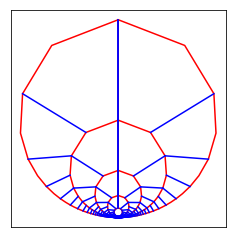

In [5]:
import itertools

class Grid(object):
    
    def __init__(self, rows=[]):
        self.pts = rows
    
    #check that you can't just hash this
    def append(self,other):
        self.pts.append(other)
        
    def __call__(self, other):
        
        for k, row in enumerate(self.pts):
            self.pts[k] = list(map(other, row))
                     
    def __getitem__(self, k) :
        return self.pts[k]     

def carleson(rpts, depth):
    # return a Grid object
    rings = Grid()
    for k in range(1,depth):
        
        T = np.linspace(0,2*np.pi, rpts*2**k/2 + 1)
        Z = np.cos(T)+  np.sin(T)*1J
        rings.append(((1  - .5**k)*Z))
   
    return rings

cc = carleson(32,6)

center = 2J
cc(lambda z : disc2plane(center, z))

tt = list(itertools.chain.from_iterable(cc))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

X, Y = [z.real for z in tt], [z.imag for z in tt]
ax.plot(X,Y,'r');

for x,y in zip(cc,cc[1:]):
    for a, b in zip(x, y[::2]):
        X, Y = [z.real for z in [a,b]], [z.imag for z in [a,b]]
        ax.plot(X,Y,'b');

So there you have it, the image of the Carleson grid in 
$\mathbb{H}^2$.

Very spider's web n'est-ce pas ?

---

## Mapping the 2nd quadrant to $\mathbb{H}^2$

There is a slightly less familiar map which  we will need.
It's the composition of 

1. $z \mapsto \frac{z}{1 - z/a}$
1. $z \mapsto -z^2$

The first map takes a (hyperbolic) half space 
bounded by $[a,0]$ to the standard halfspace

$$\{z= x + iy , x < 0, y>0 \}.$$

The second (obviously) maps this onto the whole of $\mathbb{H}^2$.



In [6]:
# the (n+1)-th map mapping a half-disc in the
# upper half plane to the whole of the upper
# half plane

# this needs screwing about with 
# to get an optimal distribution of pts
# or maybe I can do that at the end ??

def half2plane(a,z):
    
    if cmath.isinf(z): return a**2
    
    # I really don't need a cutoff here
    if z == a : return cmath.inf
    
    # the minus is here because the 2nd  quadrant
    # is mapped to the lower half plane by z -> z**2
    return -( z / (z - a) )**2


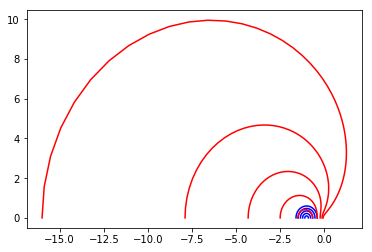

In [89]:
T = np.linspace(0, np.pi, 120)
ZS = np.cos(T) + 1J*np.sin(T)  

R  = np.linspace(.1, .6, 5)

for r in R:  
    plt_cplx( r*ZS - 1, sty='b-')
for r in R:
    WS = np.array(list(map(lambda z: half2plane(-2, z), r*ZS - 1)))
    plt_cplx(WS)

So this seems OK the concentric semicircles get mapped to a nice family of curves.

---

## The inverse map

- ```cmath.sqrt``` will take the upper half space to the first quadrant
- multiplication by ```1J``` will take the first quadrant to the second


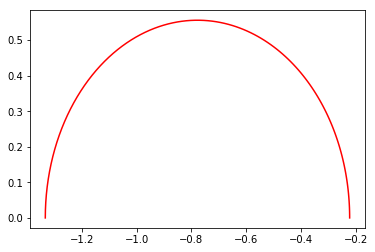

In [119]:
# check this
# the inverse of the (n+1)-th map
def plane2half(a,z):
    if z.imag < 0:
        raise ValueError('a not in upper half space') 
    
    if cmath.isinf(z):
        return a
    
    if abs(z - a**2) < 1e-11:
        return cmath.inf
    
    sq = 1J*cmath.sqrt(z)  
    return sq*a/(sq + a)

ZZ = np.array(list(map(lambda z: plane2half(-2, z), WS)))
plt_cplx(ZZ)

In [115]:
R

array([0.1  , 0.225, 0.35 , 0.475, 0.6  ])

So this seems OK the concentric semicircles get mapped to a nice family of curves.


---
## Mapping a polygon into $\mathbb{H}^2$.

The map $\phi_1$ maps 
- $z_0$ to $\infty$
- $z_1$ to $0$
- the polygon to the upper half plane $\mathbb{H}^2$.


In [7]:
def phi_1(z0, z1, z):
    ## rewrote with a cutoff
    if abs(z - z0) < 1e-11:  return cmath.inf
    return cmath.sqrt((z - z1)/(z - z0))

# the inverse of phi_1
def phi_1_inv(z0, z1, z):
    if cmath.isinf(z): return z0
    
    sq = z**2
    return (z1 - sq*z0)/(1 - sq)


### Let's just check 

- that they are inverses 
- that it does map to the upper half space

In [8]:
ws = [ phi_1(ZS[0],ZS[1],z) for z in ZS]
zs = [ phi_1_inv(ZS[0],ZS[1],z) for z in ws]
max([abs(a - b) for a,b in zip(ZS, zs)])

3.1401849173675503e-16

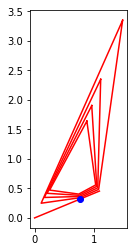

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
for k in range(5):
    tt = np.array( [ phi_1(ZS[0],ZS[1],z) 
                         for z in .9**k*ZS] )
    plt_cplx(tt, ax=ax)

plt_cplx( np.array(phi_1(ZS[0], ZS[1], ZS[2]) ) , sty='bo', ax=ax)


## The algorithm 

We have the vertices and 
we have to go round them calculating 
this $\phi_i(a, z)$.

The catch is that we have modified the vertices at each stage
so it's a kind of recursive thing.

---

Actually this is bad notation as
$$ \phi_i(a, z) = f_{z_i}(z),$$

where $z_i$ are the vertices of the domain.

---

![](unzipping.png)

---

## Degenerate case

let's start by visualizing a special case namely

- $a = i$ which means that $c=1$.

Actually if we allow rescaling of the intermediate 
polygons  <br>
so that $z_i = 1J$ we only need this map

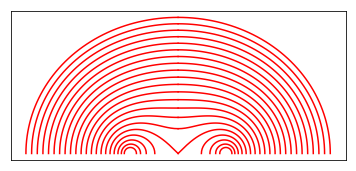

In [10]:
def f_1J(w): 
    if w == 1J : return 0
    if w == 0 : return -1
    
    S = cmath.sqrt( w**2 + 1) #again in the paper
  
    if S.real*w.real < 0: # I had to change this
        S = -S
    return S

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


T = np.linspace(0, np.pi/2, 50)
ZZ = np.cos(T) + 1J*np.sin(T)

for r in np.linspace(.5,3,21):
    WW = np.array([f_1J(z) for z in r*ZZ])
    plt_cplx(WW, ax=ax)
    plt_cplx(-WW.conjugate(),ax=ax) #use symmetry to complete

### and if $a \neq 1J$ 

As I say I don't really need this map $f_a$
if I do some rescaling but 
- it's in the paper and the thesis

In [11]:
# the i-th map made from the basic map f_a
def f(a, z):
    # don't need cutoff going through list with a in it
    if z == a: return 0
    
    if abs(a.imag) < 1e-14:
        if cmath.isfinite(z):
            return z - a
        else:
            return z

    if cmath.isfinite(z):
        w = abs(a)**2 * z / (abs(a)**2 - a.real * z)
        
    else:
        #the limit z -> infty in the expression above
        w =  - abs(a)**2 / a.real
             
    c = abs(a)**2 / a.imag
    
    if w == 0 : return -c #degenerate case
        
    S = cmath.sqrt( w**2 + c**2) #again in the paper
  
    if S.real*w.real < 0: # I had to change this
        S = -S
    return S

[(-2.378414230005443-0j), -2.1973682269356205, 0, (-2.4142135623730954+1.0000000000000004j)]
[(-16.434575491604946-0j), (-11.984317908723295-0j), -6.82842712474619, 0]


((1.003019731811276-0.08941575034209201j),
 (-0.925405586567252-0.012271477863126651j))

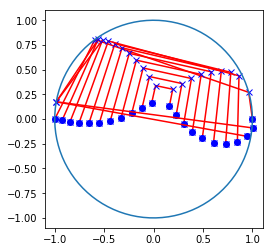

In [35]:
def poly2H2(verts, grid=Grid([]) ):
    # conf map from poly -> H^2
    # verts[0] -> \infty
    z_i = verts 
    z0, z1 = z_i[0:2]

    # apply the first map
    ff = lambda x: phi_1(z0, z1, x)
    z_i = list(map( ff, z_i))
    grid(ff)
        
    # apply the maps at each vertex
    # 
    zeta = []
    for i in range(2, len(z_i) ):
        a = z_i[i]
        # you don't really need to know the index
        zeta.append(a)
        #something subtle here 
        #we need a copy of z_i[i]
        f_i = lambda x: f(a, x)
        z_i = list(map( f_i, z_i) )
        print(z_i)
        grid(f_i)
    
    zeta.append(z_i[0])
    # map onto the whole plane
    # z_i[0] < z_i[1] < ... < z_i[-1]= 0
    # z_i[0] -> \inf, 0 -> 0
    ff = lambda x: half2plane(z_i[0], x)
    w_i = list( map(ff, z_i))
    grid(ff)
           
    return w_i, zeta


# remember I closed ZS up to make a path
ZS = diamond(4)
# we need to keep a reference as mods are inplace
grid = Grid([ r *ZS[:-1] for r in np.linspace(.1,.9, 10)])

w_i, pivots  = poly2H2(ZS[:-1], 
                  grid=grid )

# map to the disc
# as far as I can tell this was wrong  in the thesis
center = 1J
ff = lambda x: plane2disc(center, x)

ww_i = list(map(ff, w_i))
grid(ff)

## plot to see what it looks like
dd = [ww_i]
dd.extend(grid.pts)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for pts in dd:
    plt_cplx(np.array(pts[:]), sty='r-',ax=ax)
    #plt_cplx(np.array(w_i[:]), sty='bo',ax=ax)

    plt_cplx(np.array(pts[:]), sty='bx',ax=ax)
    plt_cplx(np.array([pts[0], pts[-1]]), sty='bo',ax=ax)
    
T = np.linspace(0, 2*np.pi,200)
plt.plot(np.cos(T),np.sin(T))

pts[0], pts[-1]

In [37]:
[plane2half(pivots[-1],x) for x in w_i ]



[(-16.434575491604946-0j),
 (-0.4297253511434111-2.622535003886031j),
 (-0.03068828161109501-0.709511881660153j),
 0]

In [19]:

# the inverse of the i-th map
def f_inv(a, z):
    
    if cmath.isinf(z):
        return abs(a)**2 / (1j*a.imag)
    
    sq = cmath.sqrt(z**2 + 1)
    
    if sq.imag*z.imag < 0:
        sq *= -1
        
    if abs(a.real - sq*1j*a.imag) <= 1e-11:
        return cmath.inf
    
    return sq*abs(a)**2 / (a.real - sq*1j*a.imag)

for i in reversed(range(2,len(ZS[:-1]))):
    a = pivots[i]
    w_i = list(map(lambda x: f_inv(a, x), w_i))
 
w_i

[1.4750519801160875j,
 (0.06266296631467125+1.7863713330107875j),
 (0.36294943861617895+1.6922219979689141j),
 (0.3956084617386878+1.6725228267305714j)]

In [20]:
! ./.g


[master 511c8c1] web
 1 file changed, 119 insertions(+), 66 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 42.31 KiB | 2.49 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/macbuse/CONFORMAL.git
   d8a1fbb..511c8c1  master -> master


## Experimenting with rescaling



In [557]:
def circ2vert(a, z):  
    # maps the semicircle starting at 0 and passing thru a
    # to the y-axis
    # normalized so that a -> 1J
    
    if a == z: return 1J
    if a == 0: return 0

    b = abs(a)**2/a.real
    
    ff = abs(a)**2/a.imag
    
    if cmath.isinf(z):
        return - b/ff
    
    return b*z / (b - z) / ff

def f_1J(w): 
    #maybe this is numerically better ??
    if w == 1J : return 0
    if w == 0 : return -1
    
    S = cmath.sqrt( w**2 + 1) 
    if S.real*w.real < 0: 
        S = -S
    return S

3


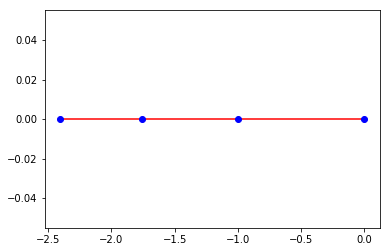

In [567]:
tt = np.copy(z_i)
for k in range(3,4):
    print(k)
    if tt[k].imag < .1**6: 
        tt -= tt[k].real
        continue
    ss = np.array( [circ2vert(tt[k], z) for z in tt[:] ])
    tt = np.array( [f_1J(z) for z in ss[:] ])
    plt_cplx(tt, sty='r-')
    plt_cplx(np.array([tt[:]]), sty='bo')
    
    

array([-2.95973103-0.j        , -2.501065  -0.j        ,
       -1.91131948-0.j        , -1.71285846-0.j        ,
       -1.65808577-0.j        , -1.6083422 -0.j        ,
       -1.48648596-0.j        , -1.36100425-0.j        ,
       -1.30218336-0.j        , -1.26200953-0.j        ,
       -1.        +0.j        ,  0.        +0.j        ,
        0.1657013 +1.27877113j, -0.68585217+1.55671133j,
       -1.670269  +1.66172407j, -2.68799567+1.20974649j])

TypeError: 'map' object is not subscriptable

In [143]:
%%timeit

def phidiscinv(a, z):
    return (a.conjugate()*z - a)/(z-1)

cc = cgrid(32,6)

a = 2J
#cc = [ list(map(lambda z : phidiscinv(a, z), rr))  for rr in cc]
cc = [phidiscinv(a, Z) for Z in cc] # have to use masks for infty
#tt = list(itertools.chain.from_iterable(cc))

2.67 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
10.7 ms vs 2.67 

# Bullshit I/O

In [ ]:
# the i-th map made from the basic map f_a
def f(a, z):
    # don't need cutoff going through list with a in it
    if z == a: return 0
    
    if cmath.isfinite(z):
        L = a.real * z / (abs(a)**2 + 1j*a.imag * z)
    else:
        if abs(a.imag) < 1e-14:
            return cmath.inf
        else:
            #the limit z -> infty in the expression above
            L = -1J * a.real / a.imag
        
    S = cmath.sqrt(L**2 - 1)
    #make S.imag L.imag same sign
    if S.imag*L.imag < 0:
        S *= -1
    return S




In [36]:
pwd


'/home/gregmcshane/CONFORMAL'